In [80]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import seaborn as sns
import sys
import pandas as pd
import random
import matplotlib.lines as mlines
import beeswarm as bs
from scipy.special import erf
from mpl_toolkits.axes_grid.inset_locator import inset_axes


# Import the project utils
import sys
sys.path.insert(0, '../utilities/')
import mwc_induction_utils as mwc
import sortseq_utils as sortseq
from sequence_logo import *
mwc.set_plotting_style()

colors=sns.light_palette(color='#b73826', n_colors=8)
colors_alt=sns.color_palette('Blues')
sns.set_palette(colors)

colors_qual=sns.color_palette(
    ['#55934d', '#b73720', '#4976b7', '#dda83d', '#985c9b'])

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Code for Figure 3

Here we compare predicted binding energies against measured binding energies. This will result in a plot of predicted versus measured energy values. We will compare predictions using the MCMC-derived scaling factor against those inferred from fitting to data. 

In [81]:
# Import matrices and fix wt at 0
O1_1027_raw = np.load('../../data/models/splits/lacThermoforTO1.npy')
O2_1027_raw = np.load('../../data/models/splits/lacThermoforTO2.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
O2_1027_fixed = np.zeros(np.shape(O2_1027_raw))

for i in range(3):
    O1_1027_fixed[i] = sortseq.fix_wt(O1_1027_raw[i], 'AATTGTGAGCGGATAACAATT')
    O2_1027_fixed[i] = sortseq.fix_wt(O2_1027_raw[i], 'AAATGTGAGCGAGTAACAACC')

    
# Import list of mutant operators

mut_ops = pd.read_csv('../../notes/Onew_mutants_list.csv')

# Import measured binding energies

measured = pd.read_csv('../../data/Onew_TF_titration_nonlinear_regression_summary.csv', index_col=0)

# Make dictionary of mutant operators and measured binding energies
energies_list = []
low_list = []
high_list = []
mut_list = []
seq_list = []
for name in mut_ops.ID:
    for op in measured.operator:
        if name.lstrip('mut') in op:
            energies_list.append(measured.energy_kBT[measured.operator==op].values[0])
            low_list.append(measured.energy_kBT_low[measured.operator==op].values[0])
            high_list.append(measured.energy_kBT_high[measured.operator==op].values[0])
            mut_list.append('O1new' + name.lstrip('mut'))
            seq_list.append(mut_ops.seq[mut_ops.ID==name].values[0])
            
# Make new dataframe storing these values
df = pd.DataFrame({'ID' : mut_list, 'sequence' : seq_list,\
                   'measured_energy' : energies_list, 'low_bound' : low_list, 'high_bound' : high_list})

# List predictions


In [82]:
# Import predictions

preds = pd.read_csv('../../notes/binding_energy_predictions.csv', index_col=0)

# Add predictions to dataframe

O1_pred_means = preds.sort_values(by='mutant')['energy_prediction_mean']\
           [(preds.matrix_operator=='O1') & (preds.matrix_repressor==130)].values
O1_pred_stds = preds.sort_values(by='mutant')['energy_prediction_std']\
           [(preds.matrix_operator=='O1') & (preds.matrix_repressor==130)].values
O2_pred_means = preds.sort_values(by='mutant')['energy_prediction_mean']\
           [(preds.matrix_operator=='O2') & (preds.matrix_repressor==130)].values
O2_pred_stds = preds.sort_values(by='mutant')['energy_prediction_std']\
           [(preds.matrix_operator=='O2') & (preds.matrix_repressor==130)].values

df['O1'] = O1_pred_means
df['O2'] = O2_pred_means
stds_list = np.append(O1_pred_stds, O2_pred_stds)

In [83]:
df.head()

,ID,high_bound,low_bound,measured_energy,sequence,O1,O2
0,O1new005,-12.165165,-12.340340,-12.242242,AATTGTGAGCGGAGAACAATT,-12.581592,-13.485146
1,O1new007,-15.178178,-15.458458,-15.297297,AATTGTGAGCGCATAACAATT,-13.475676,-14.237158
2,O1new008,-14.890891,-15.108108,-14.988989,AATTGTGAGCGGATCACAATT,-15.253542,-14.183525
3,O1new009,-12.396396,-12.627628,-12.501502,AATTGTGAGCGGAAAACAATT,-12.502816,-13.111713
4,O1new010,-11.205205,-11.408408,-11.296296,AATTGCGAGCGGATAACAATT,-11.505519,-12.160958


In [84]:
# Melt the data frame to make it tidy.
df = pd.melt(df, id_vars=['ID', 'measured_energy', 'low_bound', 'high_bound', 'sequence'], value_vars=['O1', 'O2'], \
            var_name='prediction_matrix', value_name='energy_prediction_mean')

# Add column for stds
df['energy_prediction_std'] = stds_list

# Write function to count number of differences between mutant and reference sequence
def num_diff(seq1, seq2):
    diffs = [1 for i in range(len(seq1)) if seq1[i]!=seq2[i]]
    return sum(diffs)
        
wt_dict = {'O1': 'AATTGTGAGCGGATAACAATT', 'O2' : 'AAATGTGAGCGAGTAACAACC'}

# Add a column keeping track of number of bp mutated relative to reference sequence

num_mut = []
for i in range(len(df)):
    num_mut.append(num_diff(wt_dict[df.iloc[i]['prediction_matrix']], df.iloc[i]['sequence']))
df['num_mutations'] = num_mut

# Add a column measuring the difference in magnitude between measured energy and energy prediction.
diffs = []
for i in range(len(df)):
    diffs.append(abs(df.iloc[i]['measured_energy'] - df.iloc[i]['energy_prediction_mean']))
df['error'] = diffs

df.head()

,ID,measured_energy,low_bound,high_bound,sequence,prediction_matrix,energy_prediction_mean,energy_prediction_std,num_mutations,error
0,O1new005,-12.242242,-12.340340,-12.165165,AATTGTGAGCGGAGAACAATT,O1,-12.581592,0.674349,1,0.339350
1,O1new007,-15.297297,-15.458458,-15.178178,AATTGTGAGCGCATAACAATT,O1,-13.475676,2.418769,1,1.821622
2,O1new008,-14.988989,-15.108108,-14.890891,AATTGTGAGCGGATCACAATT,O1,-15.253542,0.114562,1,0.264553
3,O1new009,-12.501502,-12.627628,-12.396396,AATTGTGAGCGGAAAACAATT,O1,-12.502816,0.698377,1,0.001315
4,O1new010,-11.296296,-11.408408,-11.205205,AATTGCGAGCGGATAACAATT,O1,-11.505519,0.524539,1,0.209223


In [85]:
# Finally, we can use groupby to find the mean error as a function of number of mutations
mean_error = df.groupby(('num_mutations', 'prediction_matrix'))['error'].mean()
mean_error = mean_error.reset_index()
mean_error.head()

,num_mutations,prediction_matrix,error
0,1,O1,0.591958
1,1,O2,0.379204
2,2,O1,0.958805
3,2,O2,0.884053
4,3,O1,1.154430


## Combine with fit figure

In [86]:
# Input function for calculating titration curves

def R_titration(energy, R):
    return(1/(1 + 2 * R/4.6E6 * np.exp(-energy)))

In [87]:
# Load all data

datadir = '../processing/'
# read the list of data-sets to ignore
data_ignore = pd.read_csv(datadir + 'datasets_ignore.csv', header=None).values
# read the all data sets except for the ones in the ignore list
all_files = glob.glob(datadir + '*O1new/output/' + '*O1new_lacI_titration_MACSQuant.csv')
ignore_files = [f for f in all_files for i in data_ignore if i[0] in f]
read_files = [f for f in all_files if f not in ignore_files]
print('Number of independent data-sets: {:d}'.format(len(read_files)))
data = pd.concat(pd.read_csv(f, comment='#') for f in read_files)

# Now we remove the autofluorescence and delta values
data = data[(data.rbs != 'auto') & (data.rbs != 'delta')]

data.head()

Number of independent data-sets: 32


,date,username,operator,binding_energy,rbs,repressors,mean_YFP_A,mean_YFP_bgcorr_A,fold_change_A
2,20160912,nbellive,01new007,-14.67,RBS1L,870,3247.302437,55.254505,0.002593
3,20160912,nbellive,01new007,-14.67,RBS1,610,3311.689537,119.641605,0.005614
4,20160912,nbellive,01new007,-14.67,RBS1027,130,3327.105063,135.057131,0.006338
5,20160912,nbellive,01new007,-14.67,RBS446,62,3388.317743,196.269811,0.009210
6,20160912,nbellive,01new007,-14.67,RBS1147,30,3442.271565,250.223633,0.011742


In [88]:
# Replace values reading "01new..." with "O1new..."
replace_dict = {}
for val in data.operator.unique():
    if val.startswith('01new'):
        replace_dict[val] = 'O1new' + val[-3:]
for key, val in replace_dict.items():
    data.replace(key, val, inplace=True)

In [89]:
# Replace incorrect binding energies with correct binding energies
energies = pd.read_csv('../../data/Onew_TF_titration_nonlinear_regression_summary.csv', index_col=0)
for op in data.operator.unique():
    if op in energies.operator.unique():
        data.replace(data.binding_energy[data.operator==op].unique(),\
                   energies.energy_kBT[energies.operator==op].unique(), inplace=True)
data.head()

,date,username,operator,binding_energy,rbs,repressors,mean_YFP_A,mean_YFP_bgcorr_A,fold_change_A
2,20160912,nbellive,O1new007,-15.297297,RBS1L,870,3247.302437,55.254505,0.002593
3,20160912,nbellive,O1new007,-15.297297,RBS1,610,3311.689537,119.641605,0.005614
4,20160912,nbellive,O1new007,-15.297297,RBS1027,130,3327.105063,135.057131,0.006338
5,20160912,nbellive,O1new007,-15.297297,RBS446,62,3388.317743,196.269811,0.009210
6,20160912,nbellive,O1new007,-15.297297,RBS1147,30,3442.271565,250.223633,0.011742


In [90]:
# Remove fold change outliers
data = data[data['fold_change_A'] < 1.1]

# Calculate log of each fold change value
fc_logs = np.log10(data.fold_change_A.values)
data['fold_change_log'] = fc_logs

# Extract the mean fold-change values for each operator-RBS pair.
mean_fc = data.groupby(('operator', 'repressors', 'binding_energy'))['fold_change_A'].mean()
mean_fc = mean_fc.reset_index()

log_mean = data.groupby(('operator', 'repressors', 'binding_energy'))['fold_change_log'].mean()
log_mean = log_mean.reset_index()

log_std = data.groupby(('operator', 'repressors', 'binding_energy'))['fold_change_log'].std()
log_std = log_std.reset_index()

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log10


In [91]:
# Establish bounds for error bars
mean_fc['error_up'] = 10**(log_mean.fold_change_log + log_std.fold_change_log)
mean_fc['error_down'] = 10**(log_mean.fold_change_log - log_std.fold_change_log)

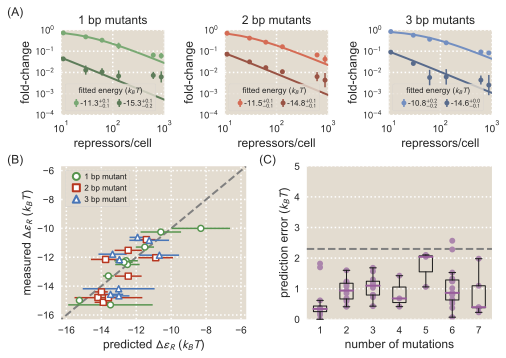

In [96]:
# Set up axes
fig = plt.figure(figsize=(7, 5))

ax0 = plt.subplot2grid((5, 6), (0, 0), colspan=2, rowspan=2)
ax1 = plt.subplot2grid((5, 6), (0, 2), colspan=2, rowspan=2)
ax2 = plt.subplot2grid((5, 6), (0, 4), colspan=2, rowspan=2)
ax3 = plt.subplot2grid((5, 6), (2, 0), colspan=3, rowspan=3)
ax4 = plt.subplot2grid((5, 6), (2, 3), colspan=3, rowspan=3)


#########################################################################

# Plot ax0, ax1, and ax2: fits of theory curves to data

mut_1 = ['O1new010', 'O1new007']
mut_2 = ['O1new105', 'O1new102']
mut_3 = ['O1new205', 'O1new201']
rep_x = np.linspace(10, 1000, 100)

for i, mut in enumerate(mut_1):
    energy = mean_fc.binding_energy[mean_fc.operator==mut].unique()
    error_up = df.high_bound[df.ID==mut].unique() - energy
    error_down = energy - df.low_bound[df.ID==mut].unique()
    temp_colors = sns.dark_palette(color='#7aa974', n_colors=4, reverse=True)
    
    # Plot 1 kBT region around theory curve
    #ax0.fill_between(rep_x, np.log10(R_titration(energy - 1, rep_x)), np.log10(R_titration(energy + 1, rep_x)),\
     #                color=temp_colors[i], alpha=0.3)
    
    # Plot theory curve
    ax0.plot(rep_x, np.log10(R_titration(energy, rep_x)), color=temp_colors[i])
    
    # Plot data points
    ax0.errorbar(log_mean.repressors[log_mean.operator==mut],\
                 log_mean.fold_change_log[log_mean.operator==mut],\
                 yerr=log_std.fold_change_log[log_mean.operator==mut], ls='', marker='o', color=temp_colors[i],\
                 zorder=9, markersize=5, elinewidth=1.5,\
                 label = (r'%0.1f$^{+%0.1f}_{-%0.1f}$' % (energy, error_up, error_down)))

    
    ax0.set_xscale('log')
    ax0.set_xlim(10, 1000)
    ax0.set_ylim(-4, 0)
    ax0.set_yticks([-4, -3, -2, -1, 0])
    ax0.set_yticklabels([r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'$10^{0}$'])
    ax0.set_title('1 bp mutants')
    ax0.set_xlabel('repressors/cell')
    ax0.set_ylabel('fold-change')
    leg=ax0.legend(fontsize=8, title=r'fitted energy ($k_BT$)', ncol=3,\
                   loc='lower left', handletextpad=-0.5, columnspacing=0.2)
    leg.get_title().set_fontsize(8)
    
for i, mut in enumerate(mut_2):
    energy = mean_fc.binding_energy[mean_fc.operator==mut].unique()
    error_up = df.high_bound[df.ID==mut].unique() - energy
    error_down = energy - df.low_bound[df.ID==mut].unique()
    temp_colors = sns.dark_palette(color='#d56c55', n_colors=4, reverse=True)
    
    # Plot 1 kBT region around theory curve
    #ax1.fill_between(rep_x, np.log10(R_titration(energy - 1, rep_x)), np.log10(R_titration(energy + 1, rep_x)),\
     #                color=temp_colors[i], alpha=0.3)
    
    # Plot theory curve
    ax1.plot(rep_x, np.log10(R_titration(energy, rep_x)), color=temp_colors[i])
    
    # Plot data points
    ax1.errorbar(log_mean.repressors[log_mean.operator==mut],\
                 log_mean.fold_change_log[log_mean.operator==mut],\
                 yerr=log_std.fold_change_log[log_mean.operator==mut], ls='', marker='o', color=temp_colors[i],
                 zorder=9, markersize=5, elinewidth=1.5,\
                 label=(r'%0.1f$^{+%0.1f}_{-%0.1f}$' % (energy, error_up, error_down)))
    
    ax1.set_xscale('log')
    ax1.set_xlim(10, 1000)
    ax1.set_ylim(-4, 0)
    ax1.set_yticks([-4, -3, -2, -1, 0])
    ax1.set_yticklabels([r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'$10^{0}$'])
    ax1.set_title('2 bp mutants')
    ax1.set_xlabel('repressors/cell')
    ax1.set_ylabel('fold-change')
    leg=ax1.legend(fontsize=8, title=r'fitted energy ($k_BT$)', ncol=3,\
                   loc='lower left', handletextpad=-0.5, columnspacing=0.2)
    leg.get_title().set_fontsize(8)
    
for i, mut in enumerate(mut_3):
    energy = mean_fc.binding_energy[mean_fc.operator==mut].unique()
    error_up = df.high_bound[df.ID==mut].unique() - energy
    error_down = energy - df.low_bound[df.ID==mut].unique()
    temp_colors = sns.dark_palette(color='#738fc1', n_colors=4, reverse=True)
    # Plot 1 kBT region around theory curve
    #ax2.fill_between(rep_x, np.log10(R_titration(energy - 1, rep_x)), np.log10(R_titration(energy + 1, rep_x)),\
     #                color=temp_colors[i], alpha=0.3)
    
    # Plot theory curve
    ax2.plot(rep_x, np.log10(R_titration(energy, rep_x)), color=temp_colors[i])
    
    # Plot data points
    ax2.errorbar(log_mean.repressors[log_mean.operator==mut],\
                 log_mean.fold_change_log[log_mean.operator==mut],\
                 yerr=log_std.fold_change_log[log_mean.operator==mut], ls='', marker='o', color=temp_colors[i],
                 zorder=9, markersize=5, elinewidth=1.5,\
                 label=(r'%0.1f$^{+%0.1f}_{-%0.1f}$' % (energy, error_up, error_down)))
    ax2.set_xscale('log')
    ax2.set_xlim(10, 1000)
    ax2.set_ylim(-4, 0)
    ax2.set_yticks([-4, -3, -2, -1, 0])
    ax2.set_yticklabels([r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'$10^{0}$'])
    ax2.set_title('3 bp mutants')
    ax2.set_xlabel('repressors/cell')
    ax2.set_ylabel('fold-change')
    leg=ax2.legend(fontsize=8, title=r'fitted energy ($k_BT$)', ncol=3,\
                   loc='lower left', handletextpad=-0.5, columnspacing=0.2)
    leg.get_title().set_fontsize(8)


##########################################################################

# Plot ax3: predictions versus measurements

ax3.plot([-17, -5], [-17, -5], ls='--', color='gray')
for name in df.ID.unique():
    pred = df.energy_prediction_mean[(df.ID==name) & (df.prediction_matrix=='O1')]
    std = df.energy_prediction_std[(df.ID==name) & (df.prediction_matrix=='O1')]
    meas = df.measured_energy[(df.ID==name) & (df.prediction_matrix=='O1')]
    lower_error = meas - df.low_bound[(df.ID==name) & (df.prediction_matrix=='O1')].values[0]
    upper_error = df.high_bound[(df.ID==name) & (df.prediction_matrix=='O1')].values[0] - meas
        
    if name.startswith('O1new2'):
        ax3.errorbar(pred, meas, xerr=std, yerr=[lower_error, upper_error], ls='', color=colors_qual[2],\
                     marker='^', markeredgewidth=1.5, markersize=6, markerfacecolor='white',\
                     markeredgecolor=colors_qual[2], zorder=9, elinewidth=1.5)
    if name.startswith('O1new1'):
        ax3.errorbar(pred, meas, xerr=std, yerr=[lower_error, upper_error], ls='', color=colors_qual[1],\
                     marker='s', markeredgewidth=1.5, markersize=6, markerfacecolor='white',\
                     markeredgecolor=colors_qual[1], zorder=9, elinewidth=1.5)
    if name.startswith('O1new0'):
        ax3.errorbar(pred, meas, xerr=std, yerr=[lower_error, upper_error], ls='', color=colors_qual[0],\
                     marker='o', markeredgewidth=1.5, markersize=6, markerfacecolor='white',\
                     markeredgecolor=colors_qual[0], zorder=9, elinewidth=1.5)
        
ax3.set_xlim(-16.3, -5.7)
ax3.set_ylim(-16.3, -5.7)
ax3.set_xlabel(r'predicted $\Delta \varepsilon_R$ ($k_BT$)')
ax3.set_ylabel(r'measured $\Delta \varepsilon_R$ ($k_BT$)')
ax3.set_xticks([-16, -14, -12, -10, -8, -6])
ax3.set_yticks([-16, -14, -12, -10, -8, -6])

# Add legend
markers = ['o', 's', '^']
names = ['1 bp mutant', '2 bp mutant', '3 bp mutant']
ims = []
for i in range(3):
    ims.append(mlines.Line2D([], [], marker=markers[i], markeredgewidth=2,\
                             markerfacecolor='white', markeredgecolor=colors_qual[i],\
                             label=names[i], linestyle='None'))
ax3.add_artist(ax3.legend(handles=ims, loc='upper left', handletextpad=0, columnspacing=0.5, fontsize=8))

        
##########################################################################

# Plot ax4: error as a function of number of mutations
medianprops = dict(linewidth=2, color=colors_qual[4])

ax4.axhline(2.3, color='gray', ls='--')

# Make lists for use in plots
error_dict = {num:df.error[df.num_mutations==num].values for num in df.num_mutations.unique()}
mut_list = []
error_list = []
for key, vals in error_dict.items():
    for val in vals:
        mut_list.append(key)
        error_list.append(val)
ax4.plot(mut_list, error_list, 'o', markersize=6, color='#ab85ac', alpha=0.75)
_ = ax4.boxplot(list(error_dict.values()), medianprops=medianprops, positions=list(error_dict.keys()))
ax4.grid(axis='x')

ax4.set_ylim(0, 5)
ax4.set_xlim(0.5, 7.5)
ax4.set_yticks([0, 1, 2, 3, 4, 5])
#ax4.set_xticks([1, 2, 3, 4, 5])
ax4.set_xlabel('number of mutations')
ax4.set_ylabel(r'prediction error ($k_BT$)')

##########################################################################

# Add figure text

plt.figtext(0.0, 0.97, '(A)', fontsize=12)
plt.figtext(0.0, 0.56, '(B)', fontsize=12)
plt.figtext(0.5, 0.56, '(C)', fontsize=12)
plt.tight_layout()

plt.savefig('fig3.pdf', bbox_inches='tight')